In [104]:
import pandas as pd 
import numpy as np 
from snorkel.labeling import labeling_function 
from snorkel.labeling import LabelingFunction
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import MajorityLabelVoter
from textblob import TextBlob 
from afinn import Afinn

In [112]:
df_train = pd.read_csv('data/train-lyrics.csv')
df_test = pd.read_csv('data/test-lyrics.csv')

In [113]:
print(df_train.columns)
print(df_test.columns)

Index(['track id', 'track name', 'artist', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'lyrics'],
      dtype='object')
Index(['track id', 'gt label', 'track name', 'artist', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'lyrics'],
      dtype='object')


In [114]:
# declare global variables
DANCE = 1
CHILL = 0
ABSTAIN = -1

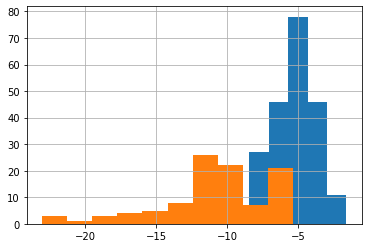

In [190]:
df_test.loc[df_test['gt label'] == 1]['loudness'].hist()
df_test.loc[df_test['gt label'] == 0]['loudness'].hist()

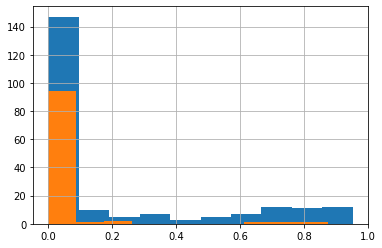

In [191]:
df_test.loc[df_test['gt label'] == 1]['instrumentalness'].hist()
df_test.loc[df_test['gt label'] == 0]['instrumentalness'].hist()

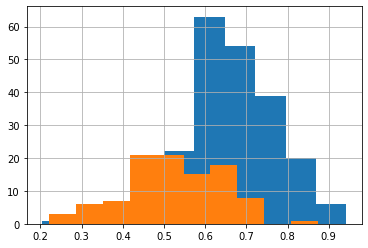

In [192]:
df_test.loc[df_test['gt label'] == 1]['danceability'].hist()
df_test.loc[df_test['gt label'] == 0]['danceability'].hist()

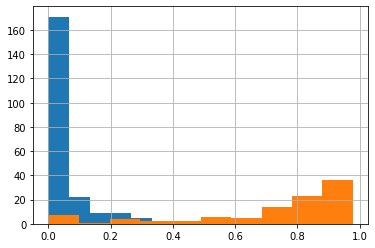

In [193]:
df_test.loc[df_test['gt label'] == 1]['acousticness'].hist()
df_test.loc[df_test['gt label'] == 0]['acousticness'].hist()

In [143]:
import re 

def clean_lyrics(lyrics): 
    ''' 
    Utility function to clean lyrics by removing links, special characters 
    using simple regex statements. 
    '''
    if pd.isnull(lyrics) or lyrics == "":
        return ''
    else:
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", lyrics).split()) 
    
lyrics = df_train['lyrics'][0]
cleaned = clean_lyrics(lyrics)
print(afinn.score(cleaned))
print(TextBlob(cleaned).sentiment.polarity)

1.0
-0.006060606060606077


In [144]:
df_train['lyrics'] = df_train['lyrics'].apply(clean_lyrics)
df_test['lyrics'] = df_test['lyrics'].apply(clean_lyrics)

In [146]:
df_train['afinn'] = df_train['lyrics'].apply(lambda x: Afinn().score(x))
df_train['sentiment'] = df_train['lyrics'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_test['afinn'] = df_test['lyrics'].apply(lambda x: Afinn().score(x))
df_test['sentiment'] = df_test['lyrics'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_train.head()

,track id,track name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,lyrics,afinn,sentiment
0,3fH4KjXFYMmljxrcGrbPj9,Don't You (Forget About Me),Simple Minds,0.660,0.816,2.0,-6.610,1.0,0.0299,0.1680,0.018100,0.0608,0.678,111.346,Hey hey hey hey Ooh-hoo-ooh-ohh Won't you come...,1.0,-0.006061
1,4RvWPyQ5RL0ao9LPZeSouE,Everybody Wants To Rule The World,Tears For Fears,0.645,0.795,7.0,-12.095,1.0,0.0527,0.3470,0.003890,0.1040,0.535,112.067,Welcome to your life There's no turning back E...,4.0,0.371429
2,58E1XVmZTODC67YNjneuXM,Tainted Love,Soft Cell,0.542,0.450,7.0,-9.931,0.0,0.0361,0.5580,0.000006,0.5790,0.626,144.437,Sometimes I feel I've got to Run away I've got...,-1.0,0.370000
3,2HuHopKnnuGQEpGb0CssCs,Hungry Like the Wolf,Duran Duran,0.654,0.903,0.0,-5.252,1.0,0.0798,0.0222,0.000000,0.2410,0.607,129.442,Darken the city night is a wire Steam in the s...,5.0,0.033333
4,1QbQL5m30YNvukitIqAnFG,Sunglasses At Night,Corey Hart,0.686,0.609,10.0,-11.469,0.0,0.0444,0.2580,0.000150,0.1130,0.719,127.736,I wear my sunglasses at night So I can so I ca...,-6.0,0.000000


In [194]:
@labeling_function()
def lf_energy(x):
    return DANCE if x['energy'] >= 0.7 else CHILL

@labeling_function()
def lf_tempo(x):
    return CHILL if x['tempo'] <= 105 else ABSTAIN

@labeling_function()
def lf_danceability(x):
    return DANCE if x['danceability'] >= 0.7 else ABSTAIN

@labeling_function()
def lf_acousticness(x):
    return DANCE if x['acousticness'] >= 0.6 else CHILL

@labeling_function()
def lf_loudness(x):
    return CHILL if x['loudness'] <= -8 else ABSTAIN



In [195]:
lfs = [lf_energy, lf_tempo, lf_danceability, lf_acousticness, lf_loudness]

# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)

# Train the label model and compute the training labels
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)

# Predict labels for the training set and also record label probabilities
df_train["label"] = label_model.predict(L=L_train, tie_break_policy="abstain")
df_train["proba"] = np.around(label_model.predict_proba(L_train), 2)[:, 1]

# Preview the results
df_train.head()



100%|██████████| 540/540 [00:00<00:00, 8309.24it/s]


,track id,track name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,lyrics,afinn,sentiment,label,proba
0,3fH4KjXFYMmljxrcGrbPj9,Don't You (Forget About Me),Simple Minds,0.660,0.816,2.0,-6.610,1.0,0.0299,0.1680,0.018100,0.0608,0.678,111.346,Hey hey hey hey Ooh-hoo-ooh-ohh Won't you come...,1.0,-0.006061,1,0.97
1,4RvWPyQ5RL0ao9LPZeSouE,Everybody Wants To Rule The World,Tears For Fears,0.645,0.795,7.0,-12.095,1.0,0.0527,0.3470,0.003890,0.1040,0.535,112.067,Welcome to your life There's no turning back E...,4.0,0.371429,1,0.71
2,58E1XVmZTODC67YNjneuXM,Tainted Love,Soft Cell,0.542,0.450,7.0,-9.931,0.0,0.0361,0.5580,0.000006,0.5790,0.626,144.437,Sometimes I feel I've got to Run away I've got...,-1.0,0.370000,0,0.08
3,2HuHopKnnuGQEpGb0CssCs,Hungry Like the Wolf,Duran Duran,0.654,0.903,0.0,-5.252,1.0,0.0798,0.0222,0.000000,0.2410,0.607,129.442,Darken the city night is a wire Steam in the s...,5.0,0.033333,1,0.97
4,1QbQL5m30YNvukitIqAnFG,Sunglasses At Night,Corey Hart,0.686,0.609,10.0,-11.469,0.0,0.0444,0.2580,0.000150,0.1130,0.719,127.736,I wear my sunglasses at night So I can so I ca...,-6.0,0.000000,0,0.08


In [196]:
print("WEIGHTS")
for a, b in zip(lfs, np.around(label_model.get_weights(), 2)):
    print(a.name, b)

WEIGHTS
lf_energy 0.76
lf_tempo 0.6
lf_danceability 0.56
lf_acousticness 0.21
lf_loudness 0.92


In [197]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_energy,0,"[0, 1]",1.000000,1.000000,0.729630
lf_tempo,1,[0],0.333333,0.333333,0.235185
lf_danceability,2,[1],0.320370,0.320370,0.318519
lf_acousticness,3,"[0, 1]",1.000000,1.000000,0.729630
lf_loudness,4,[0],0.409259,0.409259,0.311111


In [198]:
# Look at the breakdown of the predicted labels
includes = df_train.loc[df_train['label'] == 1]
excludes = df_train.loc[df_train['label'] == 0]
abstains = df_train.loc[df_train['label'] == -1]
print('INCLUDES' + '{:>5}'.format(len(includes)))
print('EXCLUDES' + '{:>5}'.format(len(excludes)))
print('ABSTAINS' + '{:>5}'.format(len(abstains)))

INCLUDES  246
EXCLUDES  294
ABSTAINS    0


In [199]:
# Use the same LFs and PandasLF Applier to predict labels and probabilities for the test set
L_test = applier.apply(df_test)
df_test["label"] = label_model.predict(L=L_test, tie_break_policy="abstain")
df_test["proba"] = np.around(label_model.predict_proba(L_test), 2)[:, 1]

# Preview the validation results
df_test.head()

100%|██████████| 319/319 [00:00<00:00, 8150.23it/s]


,track id,gt label,track name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,lyrics,afinn,sentiment,label,proba
0,2u6Jm2klS4yvAlbSHlxUwI,1.0,Alane,Robin Schulz,0.581,0.799,3,-6.660,1,0.1640,0.04190,0.000009,0.1100,0.662,124.002,,0.0,0.000000,1,0.97
1,2hCKAnd2BPo2VD65XZC3rH,1.0,Your Place or Mine,Wahlstedt,0.863,0.608,7,-2.996,1,0.1490,0.18000,0.000003,0.1140,0.389,126.053,,0.0,0.000000,1,0.56
2,73h6Ma5QhBFrshEN2CTevS,1.0,Someday,Kygo,0.612,0.686,7,-6.838,1,0.1200,0.17300,0.000000,0.1410,0.326,122.115,Come and take this heart While I'm away 'Cause...,1.0,0.081667,1,0.52
3,75rGONmoi48LLYBFaGiYsv,1.0,Both Of Us - Edit,Jayda G,0.735,0.710,11,-10.222,1,0.0766,0.00851,0.762000,0.0684,0.507,123.962,I can love enough for the both of us I can I c...,6.0,0.250000,1,0.75
4,5zn3TuX5oBHrEv8R9KyLir,1.0,Ladida (My Heart Goes Boom) [feat. ILIRA],CRISPIE,0.682,0.812,0,-4.931,1,0.0307,0.11100,0.000021,0.1370,0.455,126.040,La di da da La la la la la la Da di da da La l...,0.0,-0.031019,1,0.97


In [200]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_energy,0,"[0, 1]",1.000000,1.000000,0.729630
lf_tempo,1,[0],0.333333,0.333333,0.235185
lf_danceability,2,[1],0.320370,0.320370,0.318519
lf_acousticness,3,"[0, 1]",1.000000,1.000000,0.729630
lf_loudness,4,[0],0.409259,0.409259,0.311111


In [201]:
# Make a list of "ground truth" labels for test set
Y_test = np.array(df_test['gt label'])

In [202]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_test = majority_model.predict(L=L_test)

In [203]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="abstain")['accuracy']
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")
      
label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="abstain")['accuracy']
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   85.2%
Label Model Accuracy:     93.7%


In [204]:
# Look at the breakdown of the predicted labels on the validation set
val_includes = df_test.loc[df_test['label'] == 1]
val_excludes = df_test.loc[df_test['label'] == 0]
val_abstains = df_test.loc[df_test['label'] == -1]
print('INCLUDES' + '{:>5}'.format(len(val_includes)))
print('EXCLUDES' + '{:>5}'.format(len(val_excludes)))
print('ABSTAINS' + '{:>5}'.format(len(val_abstains)))

INCLUDES  225
EXCLUDES   94
ABSTAINS    0


In [205]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(df_test['gt label'], df_test['label']))

[[ 87  13]
 [  7 212]]
